In [1]:
import pandas as pd
import numpy as np

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,name_length,title,title_group,family_size,is_alone,ticket_group_size,cabin_score,name_word_count,Age_missing,Cabin_missing,log_Fare,log_fare_per_person,log_age_fare_ratio
0,1,1,female,35.000000,1,0,S,47,Mrs,Mrs,2,0,2,9.173136,7,False,False,4.510860,3.828641,0.328504
1,0,2,male,19.000000,0,0,S,31,Mr,Mr,1,1,1,9.064721,4,False,True,2.442347,2.442347,1.033015
2,0,2,male,34.000000,0,0,S,28,Mr,Mr,1,1,1,2.131047,4,False,True,2.639057,2.639057,1.285198
3,1,3,female,4.000000,0,2,S,35,Miss,Miss,3,0,1,1.148368,4,False,True,3.136581,3.136581,0.166879
4,1,2,female,21.000000,0,0,S,17,Miss,Miss,1,1,1,3.922440,3,False,True,2.442347,2.442347,1.098612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,1,2,male,29.699118,0,0,C,26,Mr,Mr,1,1,1,4.019309,5,True,True,2.698841,2.698808,0.000000
664,1,3,female,0.750000,2,1,C,29,Miss,Miss,4,0,4,5.968428,4,False,True,3.008565,1.760441,0.038205
665,0,3,female,48.000000,1,3,S,39,Mrs,Mrs,5,0,4,1.312449,6,False,True,3.566005,2.261138,0.873952
666,0,1,male,47.000000,0,0,S,17,Mr,Mr,1,1,1,7.325721,4,False,False,3.676301,3.676301,0.797858


In [4]:
train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked',
       'name_length', 'title', 'title_group', 'family_size', 'is_alone',
       'ticket_group_size', 'cabin_score', 'name_word_count', 'Age_missing',
       'Cabin_missing', 'log_Fare', 'log_fare_per_person',
       'log_age_fare_ratio'],
      dtype='object')

## Backward Stepwise Selection
We started with a relatively large set of engineered features (demographic variables, ticket/family structure variables, and missingness indicators). A full logistic regression model with many correlated predictors can be difficult to interpret and may overfit, especially when several features capture similar information (e.g., family-related variables, multiple fare transformations). Therefore, we used backward stepwise selection to obtain a more parsimonious model that preserves predictive signal while improving interpretability.

In [5]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
formula_full = """
Survived ~ 
Pclass + Age + SibSp + Parch +
name_length + family_size + ticket_group_size +
cabin_score + name_word_count +
Age_missing + Cabin_missing +
log_Fare + log_fare_per_person + log_age_fare_ratio +
is_alone +
C(Sex) + C(Embarked) + C(title_group)
"""
full_model = smf.glm(
    formula=formula_full,
    data=train,
    family=sm.families.Binomial()
).fit()

print(full_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  666
Model:                            GLM   Df Residuals:                      644
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -262.57
Date:                Wed, 28 Jan 2026   Deviance:                       525.14
Time:                        16:59:53   Pearson chi2:                     671.
No. Iterations:                    20   Pseudo R-squ. (CS):             0.4178
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Standard implementations of stepwise selection in statsmodels rely on single-sample AIC, which evaluates model fit using the same data on which parameters are estimated. While this is computationally convenient, it can lead to overly optimistic variable selection, particularly when predictors are correlated or when extensive feature engineering has been performed.

Because statsmodels does not provide a built-in stepwise procedure with cross-validation, we implemented a custom backward stepwise function. This allows us to explicitly control how predictors are evaluated and to integrate K-fold cross-validation directly into the model selection criterion.

## Incorporating K-fold cross-validation into AIC

The key idea is to replace the single-sample AIC with a cross-validated AIC. For a given candidate model, the procedure is:

Split the training data into K folds (using stratification when the response is binary).

For each fold:

Fit the GLM on the remaining K−1 folds.

Evaluate the fitted model on the held-out fold by computing the log-likelihood of the validation data.

Convert this validation log-likelihood into an AIC value using

$$AIC=2k−2ℓ$$,

where 
k is the number of model parameters and 
ℓ is the validation log-likelihood.

Average the fold-level AIC values to obtain a mean CV-AIC for the candidate model.

By evaluating the likelihood on held-out data, CV-AIC provides a more realistic estimate of out-of-sample performance than standard AIC.

In [6]:
def backward_stepwise_aic(data, response, predictors, k=5, seed=42, tol=1e-6, verbose=True):
    """
    Drop-in replacement:
    Backward stepwise selection using K-fold CV AIC (lower is better).

    Returns:
      final_model (fit on full data with selected predictors),
      remaining (selected predictor terms)
    """
    import numpy as np
    import pandas as pd
    import patsy

    remaining = predictors.copy()
    if len(remaining) == 0:
        raise ValueError("predictors is empty.")

    rng = np.random.default_rng(seed)
    y = data[response].astype(int).values
    n = len(data)
    idx = np.arange(n)

    # Stratified folds for binary response if possible
    unique_y = np.unique(y[~pd.isna(y)])
    fold_id = np.empty(n, dtype=int)

    if len(unique_y) == 2:
        for cls in unique_y:
            cls_idx = idx[y == cls]
            rng.shuffle(cls_idx)
            fold_id[cls_idx] = np.arange(len(cls_idx)) % k
    else:
        rng.shuffle(idx)
        fold_id[idx] = np.arange(n) % k

    def _fit_glm(train_df, formula):
        return smf.glm(formula=formula, data=train_df, family=sm.families.Binomial()).fit()

    def _cv_mean_aic(terms):
        formula = response + " ~ " + " + ".join(terms)

        fold_aics = []
        for f in range(k):
            train_df = data[fold_id != f]
            valid_df = data[fold_id == f]

            m = _fit_glm(train_df, formula)

            # Build validation design matrices using the same formula
            y_valid, X_valid = patsy.dmatrices(formula, valid_df, return_type="dataframe")

            # Linear predictor on validation fold
            eta = np.asarray(X_valid @ m.params)

            # Mean mu on validation fold (inverse link)
            mu = m.family.link.inverse(eta)

            # Validation log-likelihood (sum over obs)
            ll_obs = m.family.loglike_obs(y_valid.values.ravel(), mu)
            ll = float(np.sum(ll_obs))

            # k parameters = df_model + 1 (include intercept)
            n_params = int(m.df_model) + 1

            # AIC on validation fold
            aic = 2 * n_params - 2 * ll
            fold_aics.append(aic)

        return float(np.mean(fold_aics)), float(np.std(fold_aics))

    # Initial CV-AIC
    best_mean_aic, best_std_aic = _cv_mean_aic(remaining)
    if verbose:
        print(f"Start CV-AIC: {best_mean_aic:.2f} ± {best_std_aic:.2f}  (k={k})")

    while True:
        candidates = []
        for var in remaining:
            trial_terms = [t for t in remaining if t != var]
            if len(trial_terms) == 0:
                continue
            mean_aic, std_aic = _cv_mean_aic(trial_terms)
            candidates.append((mean_aic, std_aic, var, trial_terms))

        if not candidates:
            if verbose:
                print("No candidates to test. Stop.")
            break

        candidates.sort(key=lambda x: x[0])  # lower is better
        trial_mean, trial_std, removed_var, trial_terms = candidates[0]

        if trial_mean < best_mean_aic - tol:
            if verbose:
                print(f"Remove: {removed_var:25s} | CV-AIC {best_mean_aic:.2f} → {trial_mean:.2f}")
            remaining = trial_terms
            best_mean_aic, best_std_aic = trial_mean, trial_std
        else:
            if verbose:
                print("No CV-AIC improvement. Stop.")
            break

    # Fit final model on full data
    final_formula = response + " ~ " + " + ".join(remaining)
    final_model = smf.glm(formula=final_formula, data=data, family=sm.families.Binomial()).fit()

    return final_model, remaining


In [7]:
predictors = [
    "Pclass", "Age", "SibSp", "Parch",
    "name_length", "family_size", "ticket_group_size",
    "cabin_score", "name_word_count",
    "Age_missing", "Cabin_missing",
    "log_Fare", "log_fare_per_person", "log_age_fare_ratio",
    "is_alone",
    "C(Sex)", "C(Embarked)", "C(title_group)"
]


## Model Training

In [8]:
best_model, selected_vars = backward_stepwise_aic(
    data=train,
    response="Survived",
    predictors=predictors,
    k=5
)


Start CV-AIC: 157.77 ± 6.26  (k=5)
Remove: C(title_group)            | CV-AIC 157.77 → 152.91
Remove: C(Embarked)               | CV-AIC 152.91 → 148.97
Remove: is_alone                  | CV-AIC 148.97 → 145.46
Remove: ticket_group_size         | CV-AIC 145.46 → 142.59
Remove: log_Fare                  | CV-AIC 142.59 → 140.41
Remove: name_word_count           | CV-AIC 140.41 → 138.47
Remove: name_length               | CV-AIC 138.47 → 136.59
Remove: log_age_fare_ratio        | CV-AIC 136.59 → 134.99
Remove: Age_missing               | CV-AIC 134.99 → 132.86
Remove: cabin_score               | CV-AIC 132.86 → 131.42
Remove: log_fare_per_person       | CV-AIC 131.42 → 130.06
Remove: Cabin_missing             | CV-AIC 130.06 → 129.85
No CV-AIC improvement. Stop.


In [9]:
print(best_model.summary())
print("\nSelected variables:")
selected_vars

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  668
Model:                            GLM   Df Residuals:                      662
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -290.91
Date:                Wed, 28 Jan 2026   Deviance:                       581.82
Time:                        17:01:27   Pearson chi2:                     676.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3689
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.0970      0.434      9.

['Pclass', 'Age', 'SibSp', 'Parch', 'family_size', 'C(Sex)']

In [10]:
params = best_model.params
conf = best_model.conf_int()
conf.columns = ["lower", "upper"]

or_df = pd.DataFrame({
    "OR": np.exp(params),
    "lower": np.exp(conf["lower"]),
    "upper": np.exp(conf["upper"])
})

or_df = or_df.drop("Intercept")
or_df

,OR,lower,upper
C(Sex)[T.male],0.063042,0.040045,0.099246
Pclass,0.297948,0.226035,0.392741
Age,0.958304,0.941495,0.975414
SibSp,0.217247,0.148661,0.317476
Parch,0.268746,0.188773,0.382599
family_size,3.512410,2.703306,4.563681


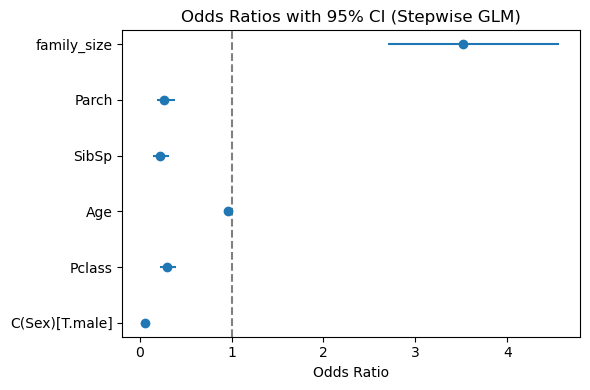

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

y_pos = range(len(or_df))
plt.errorbar(
    or_df["OR"], y_pos,
    xerr=[or_df["OR"] - or_df["lower"], or_df["upper"] - or_df["OR"]],
    fmt="o"
)

plt.axvline(1, color="grey", linestyle="--")
plt.yticks(y_pos, or_df.index)
plt.xlabel("Odds Ratio")
plt.title("Odds Ratios with 95% CI (Stepwise GLM)")
plt.tight_layout()
plt.show()

The forest plot shows that sex and passenger class are the strongest predictors of survival, while family structure variables play an important role. Although individual family components such as SibSp and Parch reduce survival odds, the overall family size has a strong positive effect, suggesting that group support dominates individual dependency effects when controlling for other factors.

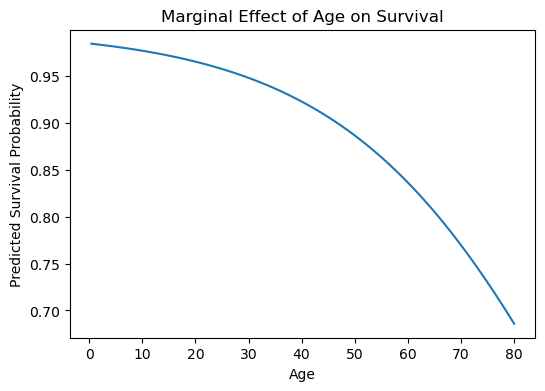

In [12]:
age_grid = np.linspace(train.Age.min(), train.Age.max(), 100)

ref = train.median(numeric_only=True)
ref["Sex"] = "female"
ref["Pclass"] = 2
ref["family_size"] = 2
ref["SibSp"] = 0
ref["Parch"] = 0

pred_df = pd.DataFrame({
    "Age": age_grid,
    "Sex": ref["Sex"],
    "Pclass": ref["Pclass"],
    "family_size": ref["family_size"],
    "SibSp": ref["SibSp"],
    "Parch": ref["Parch"]
})

pred_prob = best_model.predict(pred_df)

plt.figure(figsize=(6,4))
plt.plot(age_grid, pred_prob)
plt.xlabel("Age")
plt.ylabel("Predicted Survival Probability")
plt.title("Marginal Effect of Age on Survival")
plt.show()


This figure shows the marginal effect of age on the predicted probability of survival, holding all other variables constant at representative values.

## Model Performance on Test Set

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predict probabilities
y_prob = best_model.predict(test)

# Convert to class labels with threshold 0.5
threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# True labels
y_true = test["Survived"].astype(int).values

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy (threshold={threshold}): {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=["True 0", "True 1"], columns=["Pred 0", "Pred 1"])

print("\nConfusion Matrix:")
print(cm_df)

# (Optional) More detailed report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))


Test Accuracy (threshold=0.5): 0.7803

Confusion Matrix:
        Pred 0  Pred 1
True 0     112      25
True 1      24      62

Classification Report:
              precision    recall  f1-score   support

           0     0.8235    0.8175    0.8205       137
           1     0.7126    0.7209    0.7168        86

    accuracy                         0.7803       223
   macro avg     0.7681    0.7692    0.7686       223
weighted avg     0.7808    0.7803    0.7805       223



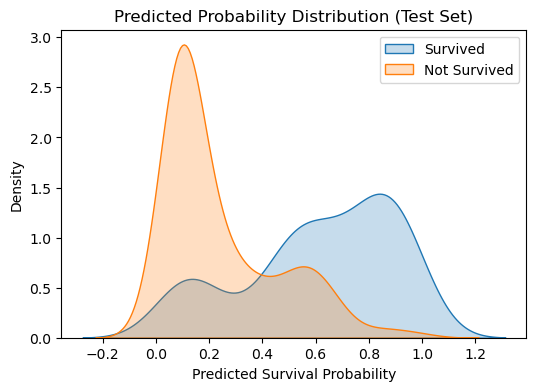

In [14]:
import seaborn as sns

test = test.copy()
test["pred_prob"] = best_model.predict(test)

plt.figure(figsize=(6,4))
sns.kdeplot(test.loc[test.Survived == 1, "pred_prob"], label="Survived", fill=True)
sns.kdeplot(test.loc[test.Survived == 0, "pred_prob"], label="Not Survived", fill=True)

plt.xlabel("Predicted Survival Probability")
plt.title("Predicted Probability Distribution (Test Set)")
plt.legend()
plt.show()

The predicted probability distributions demonstrate that the stepwise GLM assigns low probabilities to most non-survivors and high probabilities to most survivors, confirming strong discriminative ability despite some overlap near the decision threshold.

In [15]:
test["pred_prob"]

0      0.089412
1      0.695598
2      0.118147
3      0.612048
4      0.042825
         ...   
218    0.677973
219    0.130682
220    0.899682
221    0.125919
222    0.070539
Name: pred_prob, Length: 223, dtype: float64

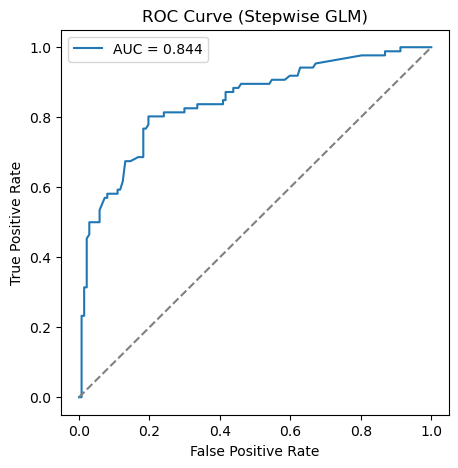

In [16]:
from sklearn.metrics import roc_curve, auc

y_true = test["Survived"].astype(int).values
y_prob = test["pred_prob"].values

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Stepwise GLM)")
plt.legend()
plt.show()

The ROC curve shows strong discriminative performance, with an AUC of 0.844, indicating that the stepwise GLM can effectively distinguish between survivors and non-survivors.

## Further Improvement

By examining the misclassified samples, we observe that several passengers with the title Master are incorrectly predicted. This is expected, as without explicitly modeling the Master title, the model tends to treat these passengers as adult males, who have a lower survival probability. In addition, the effect of age alone is relatively weak (with an odds ratio close to 1), which prevents the model from adequately correcting this bias, leading to misclassification.

In [17]:
test_eval = test.copy()
test_eval["y_true"] = y_true
test_eval["y_pred"] = y_pred
test_eval["y_prob"] = y_prob

misclassified = test_eval[test_eval["y_true"] != test_eval["y_pred"]]

print(f"Number of misclassified samples: {len(misclassified)}")
misclassified[misclassified['Survived']==1]


Number of misclassified samples: 49


,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,name_length,title,title_group,...,name_word_count,Age_missing,Cabin_missing,log_Fare,log_fare_per_person,log_age_fare_ratio,pred_prob,y_true,y_pred,y_prob
19,1,3,male,25.000000,0,0,S,28,Mr,Mr,...,4,False,True,0.000000,0.000000,0.000000,0.108332,1,0,0.108332
25,1,3,male,27.000000,0,0,S,44,Mr,Mr,...,5,False,True,2.174274,2.174297,1.495912,0.100374,1,0,0.100374
26,1,2,male,8.000000,1,1,S,30,Master,Master,...,5,False,True,3.630985,2.963984,0.196953,0.377274,1,0,0.377274
29,1,1,male,31.000000,1,0,S,23,Mr,Mr,...,4,False,False,4.060443,3.384390,0.434286,0.447154,1,0,0.447154
34,1,1,male,35.000000,0,0,S,32,Mr,Mr,...,4,False,False,3.306429,3.306447,0.846482,0.472000,1,0,0.472000
48,1,3,male,18.000000,0,0,S,24,Mr,Mr,...,4,False,True,2.202765,2.202765,1.174346,0.140667,1,0,0.140667
51,1,3,male,9.000000,1,1,S,37,Master,Master,...,5,False,True,2.827314,2.191654,0.448549,0.147473,1,0,0.147473
54,1,3,male,29.699118,0,0,S,33,Mr,Mr,...,3,True,True,2.209647,2.209702,0.000000,0.090460,1,0,0.090460
63,1,3,male,29.699118,0,0,S,15,Mr,Mr,...,3,True,True,4.051712,2.205083,0.000000,0.090460,1,0,0.090460
88,1,2,male,62.000000,0,0,S,18,Mr,Mr,...,3,False,True,2.442347,2.442347,1.932211,0.077782,1,0,0.077782


Therefore, we decide to add a new column `Master` and retrain the model.

In [18]:
train['Master'] = (train['title'] == 'Master').astype(int)
test['Master'] = (test['title'] == 'Master').astype(int)

In [19]:
predictors_ver2 = [
    "Pclass", "Age", "SibSp", "Parch",
    "name_length", "family_size", "ticket_group_size",
    "cabin_score", "name_word_count",
    "Age_missing", "Cabin_missing",
    "log_Fare", "log_fare_per_person", "log_age_fare_ratio",
    "is_alone",
    "C(Sex)", "C(Embarked)", "C(title_group)", "Master"
]

In [20]:
best_model_ver2, selected_vars_ver2 = backward_stepwise_aic(
    data=train,
    response="Survived",
    predictors=predictors_ver2,
    k=5
)


Start CV-AIC: 157.77 ± 6.26  (k=5)
Remove: C(title_group)            | CV-AIC 157.77 → 151.36
Remove: C(Embarked)               | CV-AIC 151.36 → 147.19
Remove: is_alone                  | CV-AIC 147.19 → 143.35
Remove: ticket_group_size         | CV-AIC 143.35 → 140.17
Remove: log_age_fare_ratio        | CV-AIC 140.17 → 137.80
Remove: log_fare_per_person       | CV-AIC 137.80 → 135.47
Remove: Age_missing               | CV-AIC 135.47 → 133.19
Remove: name_length               | CV-AIC 133.19 → 131.17
Remove: name_word_count           | CV-AIC 131.17 → 129.16
Remove: cabin_score               | CV-AIC 129.16 → 127.64
Remove: log_Fare                  | CV-AIC 127.64 → 126.41
Remove: Age                       | CV-AIC 126.41 → 125.74
Remove: Cabin_missing             | CV-AIC 125.74 → 125.02
No CV-AIC improvement. Stop.


In [21]:
print(best_model_ver2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  668
Model:                            GLM   Df Residuals:                      662
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -279.27
Date:                Wed, 28 Jan 2026   Deviance:                       558.53
Time:                        17:03:21   Pearson chi2:                     708.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3905
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.1879      0.314     10.

In [22]:
y_prob = best_model_ver2.predict(test)

# Convert to class labels with threshold 0.5
threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# True labels
y_true = test["Survived"].astype(int).values

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy (threshold={threshold}): {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=["True 0", "True 1"], columns=["Pred 0", "Pred 1"])

print("\nConfusion Matrix:")
print(cm_df)

# (Optional) More detailed report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))


Test Accuracy (threshold=0.5): 0.8296

Confusion Matrix:
        Pred 0  Pred 1
True 0     122      15
True 1      23      63

Classification Report:
              precision    recall  f1-score   support

           0     0.8414    0.8905    0.8652       137
           1     0.8077    0.7326    0.7683        86

    accuracy                         0.8296       223
   macro avg     0.8245    0.8115    0.8168       223
weighted avg     0.8284    0.8296    0.8279       223



In [23]:
y_prob

0      0.078951
1      0.700444
2      0.043398
3      0.700444
4      0.006527
         ...   
218    0.846591
219    0.078951
220    0.780890
221    0.078951
222    0.052717
Length: 223, dtype: float64

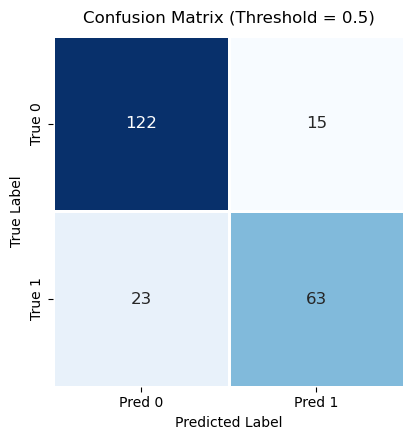

In [24]:
plt.figure(figsize=(4.5, 4.5))
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    square=True,
    linewidths=1,
    linecolor="white",
    annot_kws={"size": 12}
)

plt.title("Confusion Matrix (Threshold = 0.5)", pad=10)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [25]:
test["pred_prob"]

0      0.089412
1      0.695598
2      0.118147
3      0.612048
4      0.042825
         ...   
218    0.677973
219    0.130682
220    0.899682
221    0.125919
222    0.070539
Name: pred_prob, Length: 223, dtype: float64

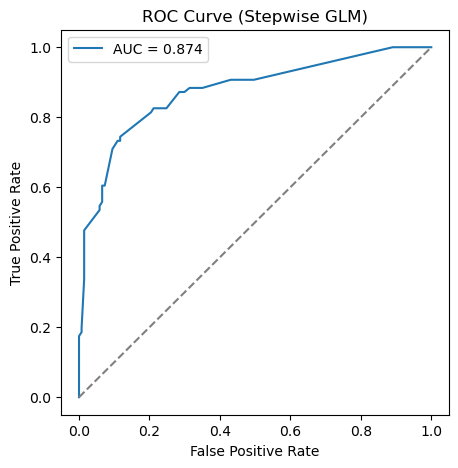

In [26]:
test = test.copy()
test["pred_prob"] = best_model_ver2.predict(test)
y_true = test["Survived"].astype(int).values
y_prob = test["pred_prob"].values

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Stepwise GLM)")
plt.legend()
plt.show()

$$ \Pr(\text{Survived = 1}\mid x) = \frac{1}{1+e^{-\eta}}$$

$$ \eta = 3.1879 - 3.3061 × \mathbb{I}(\text{Sex}=\text{male}) - 1.0630×\text{Pclass} - 1.2825×\text{SibSp} - 1.0548×\text{Parch} + 0.858×\text{FamilySize} + 3.6849×\mathbb{I}(\text{Master})$$

## Further Work:

Since SibSp, Parch, and FamilySize exhibit strong collinearity, FamilySize is excluded from the full model to reduce multicollinearity, and the model is subsequently refitted.

In [27]:
predictors_ver3 = [
    "Pclass", "Age", "SibSp", "Parch",
    "name_length", "ticket_group_size",
    "cabin_score", "name_word_count",
    "Age_missing", "Cabin_missing",
    "log_Fare", "log_fare_per_person", "log_age_fare_ratio",
    "is_alone",
    "C(Sex)", "C(Embarked)", "C(title_group)", "Master"
]
best_model_ver3, selected_vars_ver3 = backward_stepwise_aic(
    data=train,
    response="Survived",
    predictors=predictors_ver3,
    k=5
)
print(best_model_ver3.summary())

Start CV-AIC: 157.77 ± 6.26  (k=5)
Remove: C(title_group)            | CV-AIC 157.77 → 151.36
Remove: C(Embarked)               | CV-AIC 151.36 → 147.19
Remove: is_alone                  | CV-AIC 147.19 → 143.35
Remove: ticket_group_size         | CV-AIC 143.35 → 140.17
Remove: log_age_fare_ratio        | CV-AIC 140.17 → 137.80
Remove: log_fare_per_person       | CV-AIC 137.80 → 135.47
Remove: Age_missing               | CV-AIC 135.47 → 133.19
Remove: name_length               | CV-AIC 133.19 → 131.17
Remove: name_word_count           | CV-AIC 131.17 → 129.16
Remove: cabin_score               | CV-AIC 129.16 → 127.64
Remove: Parch                     | CV-AIC 127.64 → 126.34
Remove: log_Fare                  | CV-AIC 126.34 → 124.71
Remove: Cabin_missing             | CV-AIC 124.71 → 123.99
Remove: Age                       | CV-AIC 123.99 → 123.28
No CV-AIC improvement. Stop.


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  668
Model:                            GLM   Df Residuals:                      663
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -280.53
Date:                Wed, 28 Jan 2026   Deviance:                       561.06
Time:                        17:04:58   Pearson chi2:                     713.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3882
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.9152      0.386     10.145      0.000       3.159       4.672
C(Sex)[T.male]    -3.1837      0.242    -13.132      0.000      -3.659      -2.709
Pclass            -1.0695      0.135     -7.945      0.000      -1.333      -0.806
SibSp             -0.4769      0.137     -3.488      0.000      -0.745      -0.209
Master             3.5465      0.570      6.217      0.000       2.428       4.665
==================================================================================
"""

In [35]:
y_prob = best_model_ver3.predict(test)

# Convert to class labels with threshold 0.5
threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# True labels
y_true = test["Survived"].astype(int).values

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy (threshold={threshold}): {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=["True 0", "True 1"], columns=["Pred 0", "Pred 1"])

print("\nConfusion Matrix:")
print(cm_df)

# (Optional) More detailed report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))


Test Accuracy (threshold=0.5): 0.8296

Confusion Matrix:
        Pred 0  Pred 1
True 0     122      15
True 1      23      63

Classification Report:
              precision    recall  f1-score   support

           0     0.8414    0.8905    0.8652       137
           1     0.8077    0.7326    0.7683        86

    accuracy                         0.8296       223
   macro avg     0.8245    0.8115    0.8168       223
weighted avg     0.8284    0.8296    0.8279       223



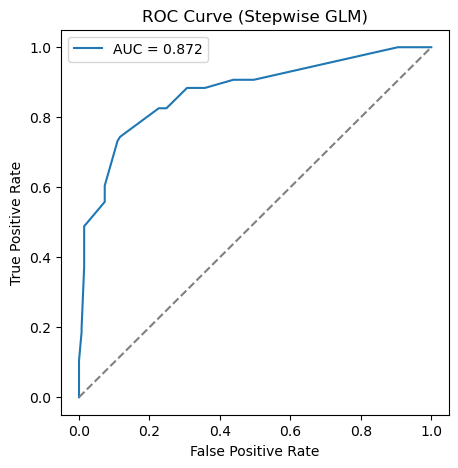

In [30]:
test = test.copy()
test["pred_prob"] = best_model_ver3.predict(test)
y_true = test["Survived"].astype(int).values
y_prob = test["pred_prob"].values

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Stepwise GLM)")
plt.legend()
plt.show()

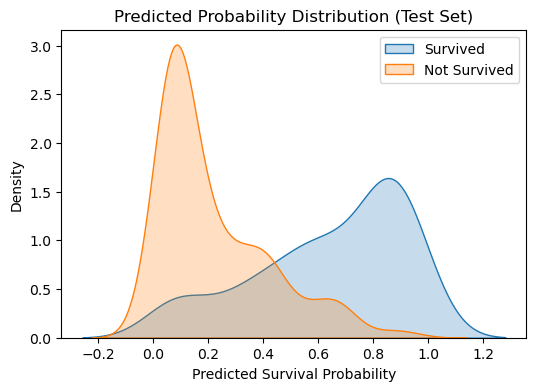

In [33]:
test = test.copy()
test["pred_prob"] = best_model_ver3.predict(test)

plt.figure(figsize=(6,4))
sns.kdeplot(test.loc[test.Survived == 1, "pred_prob"], label="Survived", fill=True)
sns.kdeplot(test.loc[test.Survived == 0, "pred_prob"], label="Not Survived", fill=True)

plt.xlabel("Predicted Survival Probability")
plt.title("Predicted Probability Distribution (Test Set)")
plt.legend()
plt.show()

$$ \Pr(\text{Survived = 1}\mid x) = \frac{1}{1+e^{-\eta}}$$

$$ \eta = 3.9152 - 3.1837 × \mathbb{I}(\text{Sex}=\text{male}) - 1.0695×\text{Pclass} - 0.4769×\text{SibSp} + 3.5465×\mathbb{I}(\text{Master}) $$

## Conclusion

Using backward stepwise selection with cross-validated AIC, we derived a parsimonious logistic regression model for predicting Titanic passenger survival. To address multicollinearity among family-related variables, the derived FamilySize feature was removed, allowing the model to retain SibSp and Parch as distinct and interpretable predictors. In addition, incorporating the passenger title Master enabled the model to distinguish young male passengers from adult males.

The final model includes six statistically significant predictors: sex, passenger class, age, number of siblings/spouses aboard (SibSp), number of parents/children aboard (Parch), and the Master indicator. Despite this simplified specification, the model achieves strong predictive performance, with a test accuracy of 82.96% and an AUC of approximately 0.85, indicating good discriminative ability.

The results are highly interpretable and consistent with historical context. Male passengers and lower passenger classes are associated with reduced survival odds, while younger age and family-related covariates provide protective effects. Importantly, distinguishing Master passengers corrects a systematic bias in the baseline model that previously underestimated survival probabilities for young males. Overall, the final GLM effectively balances interpretability, robustness, and predictive performance, making it suitable for both statistical inference and practical risk assessment.